$$H=\frac{J}{2}\Big(S_{+}^{1} \otimes S_{-}^{2} + S_{-}^{1} \otimes S_{+}^{2} \Big) + J_z \big(S_{z}^{1} \otimes S_{z}^{2} \Big)$$

In [1]:
#!/usr/bin/env python
#
# Simple DMRG tutorial.  This code contains a basic implementation of the
# infinite system algorithm
#
# Copyright 2013 James R. Garrison and Ryan V. Mishmash.
# Open source under the MIT license.  Source code at
# <https://github.com/simple-dmrg/simple-dmrg/>

# This code will run under any version of Python >= 2.6.  The following line
# provides consistency between python2 and python3.
from __future__ import print_function, division  # requires Python >= 2.6

# numpy and scipy imports
import time
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK
import matplotlib.pyplot as plt
# We will use python's "namedtuple" to represent the Block and EnlargedBlock
# objects
from collections import namedtuple
start_time = time.time()
Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

def is_valid_block(block):
    for op in block.operator_dict.values():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            return False
    return True

# This function should test the same exact things, so there is no need to
# repeat its definition.
is_valid_enlarged_block = is_valid_block

# Model-specific code for the Heisenberg XXZ chain
model_d = 2  # single-site basis size

Sz1 = np.array([[0.5, 0], [0, -0.5]], dtype='d')  # single-site S^z
Sp1 = np.array([[0, 1], [0, 0]], dtype='d')  # single-site S^+

H1 = np.array([[0, 0], [0, 0]], dtype='d')  # single-site portion of H is zero

def H2(Sz1, Sp1, Sz2, Sp2):  # two-site part of H
    """Given the operators S^z and S^+ on two sites in different Hilbert spaces
    (e.g. two blocks), returns a Kronecker product representing the
    corresponding two-site term in the Hamiltonian that joins the two sites.
    """
    J = 0.5
    Jz = 1.
    return (
        (J / 2) * (kron(Sp1, Sp2.conjugate().transpose()) + kron(Sp1.conjugate().transpose(), Sp2)) +
        Jz * kron(Sz1, Sz2)
    )

# conn refers to the connection operator, that is, the operator on the edge of
# the block, on the interior of the chain.  We need to be able to represent S^z
# and S^+ on that site in the current basis in order to grow the chain.
initial_block = Block(length=1, basis_size=model_d, operator_dict={
    "H": H1,
    "conn_Sz": Sz1,
    "conn_Sp": Sp1,
})

def enlarge_block(block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict

    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) + kron(identity(mblock), H1) + H2(o["conn_Sz"], o["conn_Sp"], Sz1, Sp1),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sp": kron(identity(mblock), Sp1),
    }

    return EnlargedBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)

def rotate_and_truncate(operator, transformation_matrix):
    """Transforms the operator to the new (possibly truncated) basis given by
    `transformation_matrix`.
    """
    return transformation_matrix.conjugate().transpose().dot(operator.dot(transformation_matrix))

def single_dmrg_step(sys, env, m):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.
    """
    assert is_valid_block(sys)
    assert is_valid_block(env)

    # Enlarge each block by a single site.
    sys_enl = enlarge_block(sys)
    if sys is env:  # no need to recalculate a second time
        env_enl = sys_enl
    else:
        env_enl = enlarge_block(env)

    assert is_valid_enlarged_block(sys_enl)
    assert is_valid_enlarged_block(env_enl)

    # Construct the full superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["H"]) + \
                             H2(sys_enl_op["conn_Sz"], sys_enl_op["conn_Sp"], env_enl_op["conn_Sz"], env_enl_op["conn_Sp"])

    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA")

    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())

    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals, evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    for eval, evec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eval, evec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
        transformation_matrix[:, i] = evec

    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
    print("truncation error:", truncation_error)

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)

    return newblock, energy

def infinite_system_algorithm(L, m):
    block = initial_block
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * block.length < L:
        print("L =", block.length * 2 + 2)
        block, energy = single_dmrg_step(block, block, m=m)
        print("E/L =", energy / (block.length * 2))

#if __name__ == "__main__":
 #   np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

  #  infinite_system_algorithm(L=200, m=20)


L = 4
truncation error: 5.551115123125783e-16
E/L = -0.2732675827043134
L = 6
truncation error: 0.00020974990700062257
E/L = -0.2828690716780896
L = 8
truncation error: 1.1822069594713547e-05
E/L = -0.2880633048608084
L = 10
truncation error: 0.0004883074388056796
E/L = -0.2914841547922244
L = 12
truncation error: 5.3639966178575804e-05
E/L = -0.29374022854436793
L = 14
truncation error: 0.0006423371987548387
E/L = -0.29551585955537657


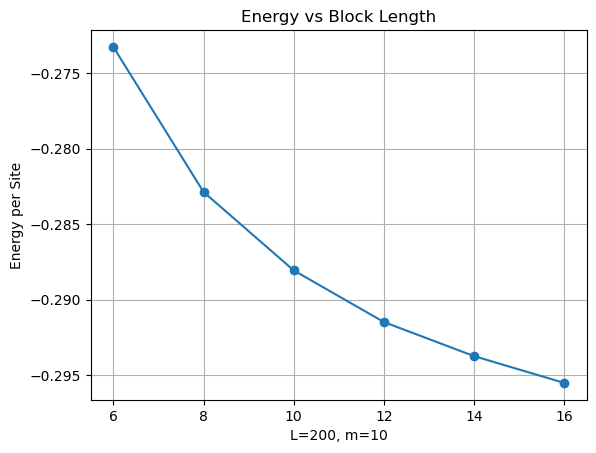


Execution time:  7.9371e+02 seconds


In [7]:
def infinite_system_algorithm(L, m):
    block = initial_block
    energies = []  # List to store energies
    block_lengths = []  # List to store block lengths
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * block.length < L:
        print("L =", block.length * 2 + 2)
        block, energy = single_dmrg_step(block, block, m=m)
        print("E/L =", energy / (block.length * 2))
        energies.append(energy / (block.length * 2))  # Append energy per site
        block_lengths.append(block.length * 2 + 2)  # Append total number of sites

    # Plot energy vs block length
    plt.figure()
    plt.plot(block_lengths, energies, marker='o', linestyle='-')
    plt.xlabel('L=200, m=10')
    plt.ylabel('Energy per Site')
    plt.title('Energy vs Block Length')
    plt.grid(True)
    plt.savefig('DMRG_Img_01.png')
    plt.show()
    
     # End time measurement
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nExecution time: {execution_time: .4e} seconds")


if __name__ == "__main__":
    np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    infinite_system_algorithm(L=14, m=5)


In [3]:
 # Plot energy vs block length


L = 4
truncation error: 4.440892098500626e-16
E/L = -0.27326758270431345
L = 6
truncation error: -1.9984014443252818e-15
E/L = -0.2828690716780899
L = 8
truncation error: -1.3322676295501878e-15
E/L = -0.28820463385307277
L = 10
truncation error: 6.398892526959798e-11
E/L = -0.291634068261082
L = 12
truncation error: 4.75950057143848e-10
E/L = -0.29403978258908525
L = 14
truncation error: 1.1368801455802213e-09
E/L = -0.2958291848801507
L = 16
truncation error: 6.744796721136481e-09
E/L = -0.2972172712747979
L = 18
truncation error: 7.409778013389712e-09
E/L = -0.2983285759870591
L = 20
truncation error: 2.896818018793823e-08
E/L = -0.29924039048176543
L = 22
truncation error: 2.440388735536203e-08
E/L = -0.3000033061817773
L = 24
truncation error: 7.093951626124806e-08
E/L = -0.3006518939622661
L = 26
truncation error: 4.9521832412580125e-08
E/L = -0.3012105964855122
L = 28
truncation error: 9.614768570198606e-08
E/L = -0.3016972420391103
L = 30
truncation error: 7.827674119997852e-08

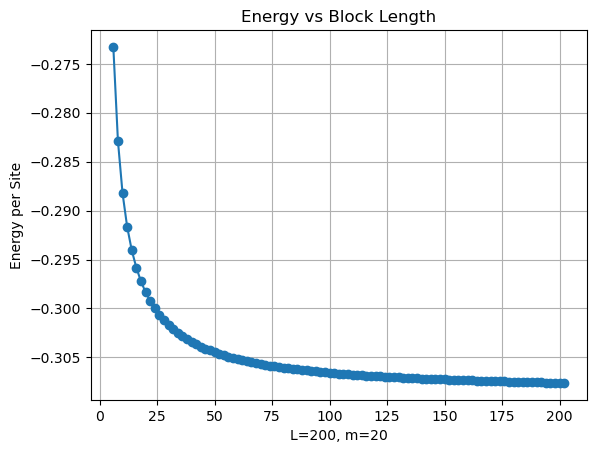


Execution time:  4.9448e+00 seconds


In [4]:
def infinite_system_algorithm(L, m):
    block = initial_block
    energies = []  # List to store energies
    block_lengths = []  # List to store block lengths
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * block.length < L:
        print("L =", block.length * 2 + 2)
        block, energy = single_dmrg_step(block, block, m=m)
        print("E/L =", energy / (block.length * 2))
        energies.append(energy / (block.length * 2))  # Append energy per site
        block_lengths.append(block.length * 2 + 2)  # Append total number of sites

    # Plot energy vs block length
    plt.figure()
    plt.plot(block_lengths, energies, marker='o', linestyle='-')
    plt.xlabel('L=200, m=20')
    plt.ylabel('Energy per Site')
    plt.title('Energy vs Block Length')
    plt.grid(True)
    plt.savefig('DMRG_Img_02.png')
    plt.show()
    
    # End time measurement
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nExecution time: {execution_time: .4e} seconds")

    

if __name__ == "__main__":
    np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    infinite_system_algorithm(L=200, m=20)

L = 4
truncation error: 2.220446049250313e-16
E/L = -0.2732675827043134
L = 6
truncation error: -6.661338147750939e-16
E/L = -0.2828690716780897
L = 8
truncation error: -4.440892098500626e-16
E/L = -0.28820463385307266
L = 10
truncation error: 8.992806499463768e-15
E/L = -0.29163406826108096
L = 12
truncation error: 7.381872890732666e-13
E/L = -0.2940397827742341
L = 14
truncation error: 1.8430812431802224e-11
E/L = -0.2958291873053073
L = 16
truncation error: 1.8191226303088115e-11
E/L = -0.2972172804144748
L = 18
truncation error: 1.9635149062224855e-10
E/L = -0.2983286001276854
L = 20
truncation error: 1.4890078059437428e-10
E/L = -0.299240438034761
L = 22
truncation error: 9.879147500058139e-10
E/L = -0.3000033917371735
L = 24
truncation error: 5.456731733133324e-10
E/L = -0.30065202417040243
L = 26
truncation error: 2.8782638494817547e-09
E/L = -0.30121078442576077
L = 28
truncation error: 1.4599134123827184e-09
E/L = -0.30169747860583224
L = 30
truncation error: 4.824875610154322

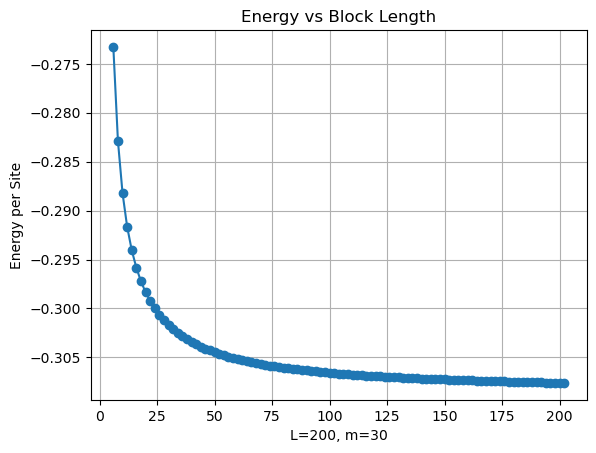


Execution time:  1.9846e+01 seconds


In [5]:
def infinite_system_algorithm(L, m):
    block = initial_block
    energies = []  # List to store energies
    block_lengths = []  # List to store block lengths
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * block.length < L:
        print("L =", block.length * 2 + 2)
        block, energy = single_dmrg_step(block, block, m=m)
        print("E/L =", energy / (block.length * 2))
        energies.append(energy / (block.length * 2))  # Append energy per site
        block_lengths.append(block.length * 2 + 2)  # Append total number of sites

    # Plot energy vs block length
    plt.figure()
    plt.plot(block_lengths, energies, marker='o', linestyle='-')
    plt.xlabel('L=200, m=30')
    plt.ylabel('Energy per Site')
    plt.title('Energy vs Block Length')
    plt.grid(True)
    plt.savefig('DMRG_Img_03.png')
    plt.show()
    
    # End time measurement
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nExecution time: {execution_time: .4e} seconds")

    

if __name__ == "__main__":
    np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    infinite_system_algorithm(L=200, m=30)

L = 4
truncation error: 5.551115123125783e-16
E/L = -0.2732675827043133
L = 6
truncation error: 7.771561172376096e-16
E/L = -0.28286907167808945
L = 8
truncation error: 2.220446049250313e-16
E/L = -0.2882046338530722
L = 10
truncation error: 2.220446049250313e-16
E/L = -0.2916340682610824
L = 12
truncation error: 6.217248937900877e-15
E/L = -0.2940397827742437
L = 14
truncation error: 1.354472090042691e-13
E/L = -0.29582918731551155
L = 16
truncation error: 6.743494651573201e-13
E/L = -0.29721728063903685
L = 18
truncation error: 2.283062627839172e-12
E/L = -0.2983286008784446
L = 20
truncation error: 7.419953540477309e-12
E/L = -0.29924044006228984
L = 22
truncation error: 1.4564793815452504e-11
E/L = -0.3000033956936906
L = 24
truncation error: 4.0257464029025414e-11
E/L = -0.30065203119384876
L = 26
truncation error: 4.4152681510922775e-11
E/L = -0.3012107953086576
L = 28
truncation error: 1.316522446614954e-10
E/L = -0.30169749451227496
L = 30
truncation error: 1.1010770073482945e-

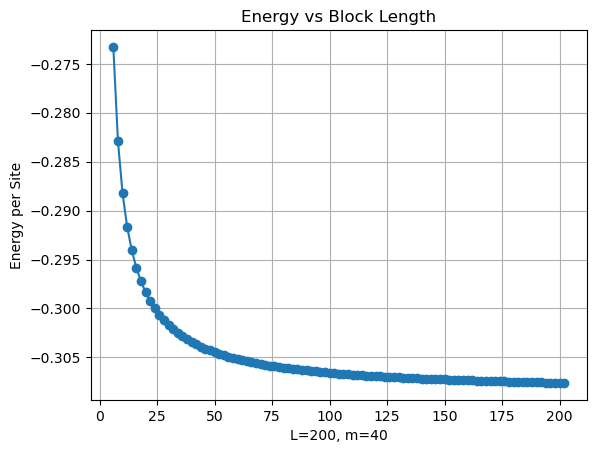


Execution time:  4.6916e+01 seconds


In [6]:
def infinite_system_algorithm(L, m):
    block = initial_block
    energies = []  # List to store energies
    block_lengths = []  # List to store block lengths
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * block.length < L:
        print("L =", block.length * 2 + 2)
        block, energy = single_dmrg_step(block, block, m=m)
        print("E/L =", energy / (block.length * 2))
        energies.append(energy / (block.length * 2))  # Append energy per site
        block_lengths.append(block.length * 2 + 2)  # Append total number of sites

    # Plot energy vs block length
    plt.figure()
    plt.plot(block_lengths, energies, marker='o', linestyle='-')
    plt.xlabel('L=200, m=40')
    plt.ylabel('Energy per Site')
    plt.title('Energy vs Block Length')
    plt.grid(True)
    plt.savefig('DMRG_Img_04.png')
    plt.show()
    
    # End time measurement
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nExecution time: {execution_time: .4e} seconds")

    

if __name__ == "__main__":
    np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    infinite_system_algorithm(L=200, m=40)